## Задание 2: Сравнение алгоритмов оптимизации

Для практической части мы пользуемся библиотекой `numpy`: [документация](https://numpy.org/doc/)

Не пользуйтесь другими библиотеками (`torch`, `jax` и тп)

In [ ]:
from typing import Callable
import time
from functools import partial
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import requests

Подготовим данные

In [ ]:
url = 'https://drive.google.com/uc?id=1vcd064Gz1Apf9Tz-VkSSkchwPZopBh98'
filename = 'mushrooms.txt'

response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)

In [ ]:
data = load_svmlight_file(filename)
mushrooms_x, mushrooms_y = data[0].toarray(), data[1]
# сделаем y -1 или 1
mushrooms_y = 2 * mushrooms_y - 3

Разделим данные на train/test

**Важно:** не меняйте код ниже. random_state зафиксирован для воспроизводимости.

In [ ]:
train_mush_x, test_mush_x, train_mush_y, test_mush_y = train_test_split(
    mushrooms_x, mushrooms_y, test_size=0.2, random_state=42
)

print(f"{train_mush_x.shape=}")
print(f"{train_mush_y.shape=}")

train_mush_x.shape=(6499, 112)
train_mush_y.shape=(6499,)


### Задача 0 (1 балл)

Найдите константу гладкости $L$ согласно (4) на практике для `train_mush_x`.

---

In [ ]:
def get_lipschitz(x_values: np.ndarray) -> float:
    X= x_values
    N= X.shape[0]
    gram= X.T@X
    lam_max= np.linalg.eigvalsh(gram)[-1]
    L0= lam_max/(4.0*N)
    L= float(L0/(1.0-1.0/1000.0))

    return L

In [ ]:
get_lipschitz(train_mush_x)

2.5872260889612666

In [ ]:
def assert_lipschitz(get_lipschitz: Callable) -> None:
    true_lipschitz = 2.5872260889612666
    your_lipschitz = get_lipschitz(train_mush_x)
    assert np.allclose(true_lipschitz, your_lipschitz, atol=1e-6), "Failed on get_lipschitz(train_mush_x)"
    print("Success!!!")

assert_lipschitz(get_lipschitz)

Success!!!


In [ ]:
lipschitz_mush = get_lipschitz(train_mush_x)
lambda_mush = lipschitz_mush / 1000

### Задача 1 (2 балла)

Реализуйте подсчёт значения, градиента и гессиана целевой функции (3).

In [ ]:
def mush_exp(x: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # TODO: Calculate exp(-y * <w,x>)
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    return np.exp(-(y*(x@w)))


def mush_f(
    w: np.ndarray, x: np.ndarray = train_mush_x, y: np.ndarray = train_mush_y
) -> float:
    # TODO: Calculate loss function
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    N= x.shape[0]
    lam= globals().get("lambda_mush", 0.0)
    s= y*(x@w)
    loss= np.mean(np.logaddexp(0.0,-s))
    reg= 0.5*lam*(w@w)
    res= float(loss+reg)
    return res


def mush_grad(
    w: np.ndarray, x: np.ndarray = train_mush_x, y: np.ndarray = train_mush_y
) -> np.ndarray:
    # TODO: Calculate gradient of loss function
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    N= x.shape[0]
    lam= globals().get("lambda_mush", 0.0)
    s= y*(x@w)
    p= np.exp(-np.logaddexp(0.0, s))
    grad= -(x.T@(y*p))/N+lam*w
    return grad


def mush_hess(
    w: np.ndarray, x: np.ndarray = train_mush_x, y: np.ndarray = train_mush_y
) -> np.ndarray:
    # TODO: Calculate hessian of loss function
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################
    N= x.shape[0]
    d= x.shape[1]
    lam= globals().get("lambda_mush", 0.0)
    s= y*(x@w)
    p= np.exp(-np.logaddexp(0.0, s))
    dweights= p*(1.0-p)
    H= ((x.T*dweights)@x)/N+lam*np.eye(d)
    return H


def mush_accuracy(
    w: np.ndarray, x: np.ndarray = test_mush_x, y: np.ndarray = test_mush_y
) -> float:
    if len(x) == 0:
        return 0
    return np.mean((np.sign(x @ w) == y))

In [ ]:
def assert_mush(mush_f: Callable, mush_grad: Callable, mush_hess: Callable):
    w = np.zeros(train_mush_x[0].shape[0])
    assert np.allclose(mush_f(w), 0.6931471805599453, atol=1e-6), "Failed on mush_f(w) for w=0"
    assert np.allclose(mush_grad(w).sum(), -0.3732112632712724, atol=1e-6), "Failed on mush_grad(w) for w=0"
    assert np.allclose(mush_hess(w).sum(), 110.53976932196366, atol=1e-6), "Failed on mush_hess(w) for w=0"

    w = np.ones(train_mush_x[0].shape[0])
    assert np.allclose(mush_f(w), 10.271673398468815, atol=1e-6), "Failed on mush_f(w) for w=1"
    assert np.allclose(mush_grad(w).sum(), 10.416558042769106, atol=1e-6), "Failed on mush_grad(w) for w=1"
    assert np.allclose(mush_hess(w).sum(), 0.2897696563545762, atol=1e-6), "Failed on mush_hess(w) for w=1"
    print("Success!!!")

assert_mush(mush_f, mush_grad, mush_hess)

Success!!!


### Задача 2 (2 балла)

Рассмотрим и реализуем метод градиентного спуска (Gradient Descent)

$$
\begin{equation*}
w_{k+1} = w_k - \gamma_k \nabla \mathcal{L}(w_k)
\end{equation*}
$$

In [ ]:
# Фиксируем рандомизацию для воспроизводимости
seed = 42
np.random.seed(seed)
start_w_mush = np.random.randn(train_mush_x.shape[1])

In [ ]:
# Базовый класс оптимизатора
class ManualSolver:
    def __init__(
        self,
        lr: float | Callable, # Скорость обучения
        name: str, # Название оптимизатора (для логгирования)
        first_order: bool, # Использует ли оптимизатор grad_f
        second_order: bool, # Использует ли оптимизатор hess_f
    ) -> None:
        super().__init__()
        self.name = name
        self.lr = lr if isinstance(lr, Callable) else lambda _: lr
        self.first_order = first_order
        self.second_order = second_order

    def step(self, w: np.ndarray, k: int, grad_f: np.ndarray, hess_f: np.ndarray) -> np.ndarray:
        # эту функцию должны переопределить наследуемые классы
        raise NotImplementedError

#### Задача 2.1

Реализуйте шаг обучения и тестирования.

**Важно:** критерием сходимости является отношение $\frac{\| \nabla f(w^k) \|}{\| \nabla f(w^0) \|}$ на **обучающей** выборке. В связи с этим, подсчет `grad_norm`$=\| \nabla f(w^k) \|$ необходимо производить на обучающей выборке `train_mush_x`.

Подсчет точности и лосса в `eval_optimizer_step` проводятся на тестовой выборке.

In [ ]:
def train_optimizer_step(
    optimizer: ManualSolver,
    w: np.ndarray,
    iter_num: int,
    x: np.ndarray = train_mush_x,
    y: np.ndarray = train_mush_y
) -> np.ndarray:
    # TODO: implement train_step pipeline;
    # OUTPUT: Updated training weights
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################

    grad= mush_grad(w, x, y) if getattr(optimizer, "first_order", True) else None
    hess= mush_hess(w, x, y) if getattr(optimizer, "second_order", False) else None
    updated_w= optimizer.step(w=w, k=iter_num, grad_f=grad, hess_f=hess)

    return updated_w

In [ ]:
def eval_optimizer_step(
    w: np.ndarray,
    x: np.ndarray = test_mush_x,
    y: np.ndarray = test_mush_y
) -> list[float, float, float]:
    # TODO: implement eval pipeline;
    # OUTPUT: [grad_norm, accuracy, val_loss]
    # You need to calculate `grad_norm` on train_mush_x!!
    # YOUR CODE HERE:
    ###########################
    ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    ###########################

    grad_norm= np.linalg.norm(mush_grad(w, train_mush_x, train_mush_y))

    accuracy= mush_accuracy(w, x, y)
    val_loss= mush_f(w, x, y)
    return [grad_norm, accuracy, val_loss]

In [ ]:
def test_optimizer(
    optimizer: ManualSolver,
    max_iters: int = 1000,
    start_w: np.ndarray = start_w_mush,
    stop_criterion: float = 1e-8,
) -> dict:

    accuracies = []
    losses = []
    criterion_logs = []  # нормы градиента или что-то другое
    time_logs = []

    w = start_w.copy()

    # initial eval
    start_grad_norm, accuracy, val_loss = eval_optimizer_step(w)
    time_logs.append(0)
    criterion_logs.append(start_grad_norm / start_grad_norm)
    accuracies.append(accuracy)
    losses.append(val_loss)

    start_time = time.time()

    with tqdm(range(max_iters), desc=optimizer.name) as loop:
        for k in loop:
            # train
            w = train_optimizer_step(optimizer, w, k)
            # eval
            grad_norm, accuracy, val_loss = eval_optimizer_step(w)
            criterion_logs.append(grad_norm / start_grad_norm)
            accuracies.append(accuracy)
            losses.append(val_loss)
            time_logs.append(time.time() - start_time)
            loop.set_postfix(
                {"Loss": val_loss, "Accuracy": accuracy, "Grad norm": grad_norm / start_grad_norm}
            )
            # Остановить, если criterion <= stop_criterion
            if grad_norm / start_grad_norm <= stop_criterion:
                break

    results_dict = {
        "name": optimizer.name,
        "num_iters": list(range(len(accuracies))),
        "Time": time_logs,
        "Accuracy": accuracies,
        "Criterion": criterion_logs,
        "Loss": losses,
        "W": w.copy(),
    }

    return results_dict

In [ ]:
def plot_results(results_dictionaries: list, title: str, metrics_type: list = ['Criterion'], x: str = 'num_iters') -> None:
    valid_metrics = {'Criterion', 'Accuracy', 'Loss'}
    assert all(metric in valid_metrics for metric in metrics_type), \
        f"All metrics should be one of {valid_metrics}, got {metrics_type}"

    assert x in ['num_iters', 'Time'], f"x should be one of ['num_iters', 'Time'], got {x}"

    num_metrics = len(metrics_type)
    if num_metrics == 1:
        width = 10
    else:
        width = 6 * num_metrics
    fig, axs = plt.subplots(1, num_metrics, figsize=(width, 6), sharey=False)
    if num_metrics == 1:
        axs = [axs]

    for idx, metric_type in enumerate(metrics_type):
        ax = axs[idx]
        for results_dict in results_dictionaries:
            if metric_type == 'Criterion':
                ax.set_yscale('log')
            ax.plot(
                results_dict[x],
                results_dict[metric_type],
                label=results_dict["name"],
                linewidth=2
            )
        ylabel = f"log {metric_type}" if metric_type == 'Criterion' else metric_type
        ax.set_xlabel(x, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.legend(loc='best', fontsize=12)
        ax.grid(True)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### Задача 2.2

- Реализуйте метод градиентного спуска
- Проведите оптимизацию гиперпараметров . Сравнения проиллюстрируйте на графике. Критерием задачи является $\frac{\| \nabla f(w^k) \|}{\| \nabla f(w^0) \|}$. Однако приветствуются также графики точности и функции потерь на тесте:
1.  Протестируйте различные $\gamma_k = \gamma = \frac{s}{L}$, где $s \in [0, 3]$, $L$ -- константа липшица в задаче. Рассмотрите не менее 4-х $s$;
2. Протестируйте различные $\gamma_k = \frac{\gamma}{\delta + k}$, где $\gamma, \delta \in [1, 100]$. Рассмотрите не менее 4-х гиперпараметров;
3. Протестируйте различные $\gamma_k = \frac{\gamma}{\delta + \sqrt{k}}$, где $\gamma, \delta \in [1, 100]$. Рассмотрите не менее 4-х гиперпараметров;
4. Выберите лучшие $\gamma^1_k$, $\gamma^2_k$, $\gamma^3_k$ из п. 1-3 соответственно. Сделайте общий график, сравнивающий их. Также добавьте базовый $\gamma_k = \gamma = 10^{-3}$.

In [ ]:
class GradientDescent(ManualSolver):
    def __init__(self, lr, name) -> None:
        super().__init__(lr, name, True, False)
    def step(self, w: np.ndarray, k: int, grad_f: np.ndarray, hess_f: None) -> np.ndarray:
        # TODO: init GradientDescent step
        # YOUR CODE HERE:
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        return w-self.lr(k)*grad_f

GD lr=1e-3: 100%|██████████| 1000/1000 [00:09<00:00, 104.90it/s, Loss=1.12, Accuracy=0.66, Grad norm=0.47]


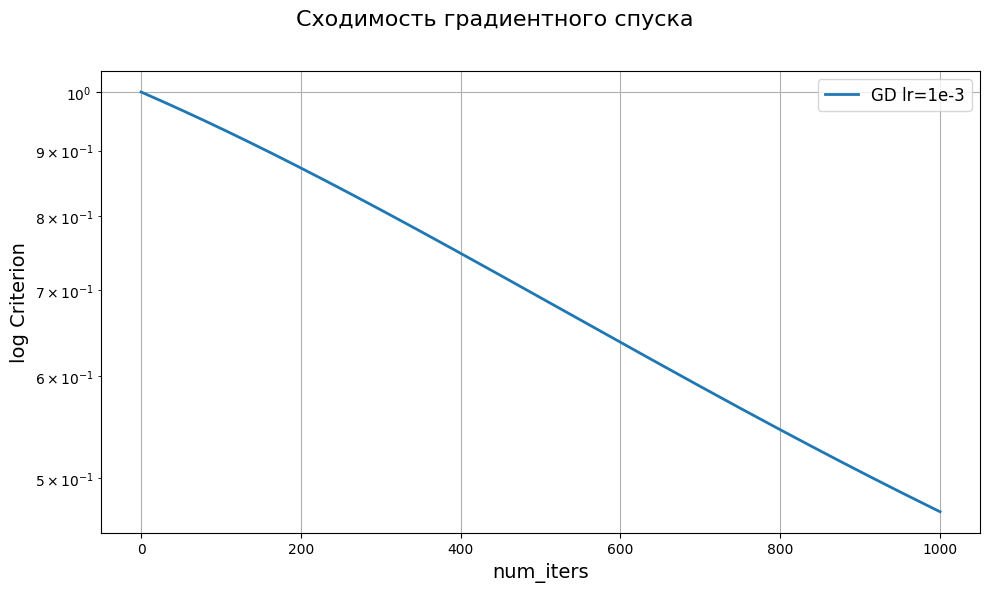

In [ ]:
grad_opt = GradientDescent(lr=1e-3, name='GD lr=1e-3')
gd_res_baseline = test_optimizer(grad_opt)
plot_results([gd_res_baseline], 'Cходимость градиентного спуска')

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
s_values= [0.25, 0.5, 1.0, 1.5, 2.0, 3.0]
gd_const_res= []

for s in s_values:
    opt= GradientDescent(lr=s/lipschitz_mush, name=f'GradDesc, {s}/L')
    gd_const_res.append(test_optimizer(opt))



GradDesc, 3.0/L: 100%|██████████| 1000/1000 [00:08<00:00, 120.67it/s, Loss=0.0835, Accuracy=0.996, Grad norm=0.000599]


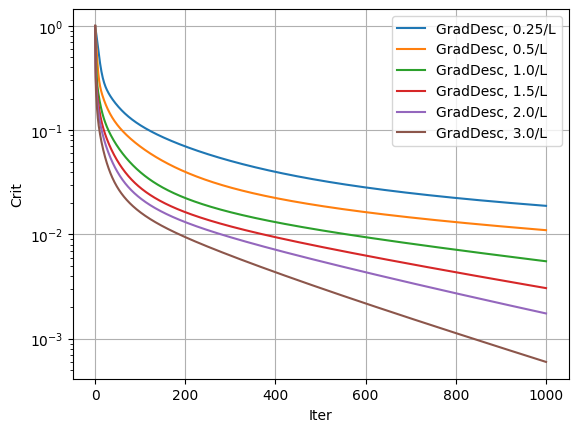

In [ ]:
for res in gd_const_res:
    plt.plot(res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

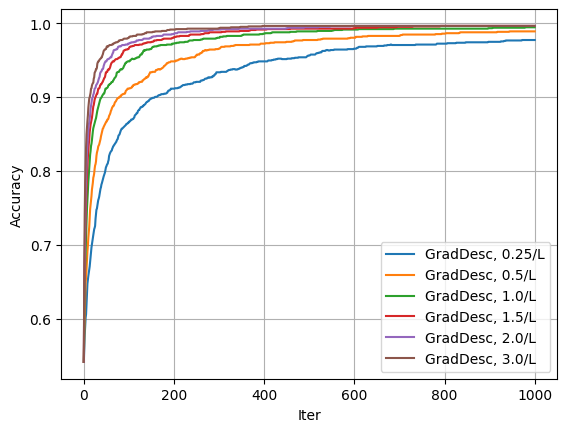

In [ ]:
for res in gd_const_res:
    plt.plot(res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [ ]:
best_final_gd_res = min(gd_const_res, key=lambda x: x['Criterion'][-1])

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

def dynamic_lr(initial_gamma, delta):
    # TODO: return a lambda function that depends on k
    return lambda k: initial_gamma/(k+delta)

In [ ]:

# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
def dynamic_lr_sqrt(initial_gamma, delta):
    # TODO: return a lambda function that depends on √k
    return lambda k: initial_gamma/np.sqrt(k+delta)

In [ ]:

# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

initial_gamma = 1.0 / lipschitz_mush
deltas = [1, 5, 10, 50, 100]
gd_sqrt_res = []

for delta in deltas:
    lr_fun = dynamic_lr_sqrt(initial_gamma, delta)
    opt = GradientDescent(lr=lr_fun, name=f'γ0/sqrt(k+{delta})')
    gd_sqrt_res.append(test_optimizer(opt))


γ0/sqrt(k+100): 100%|██████████| 1000/1000 [00:06<00:00, 163.58it/s, Loss=0.346, Accuracy=0.906, Grad norm=0.074]


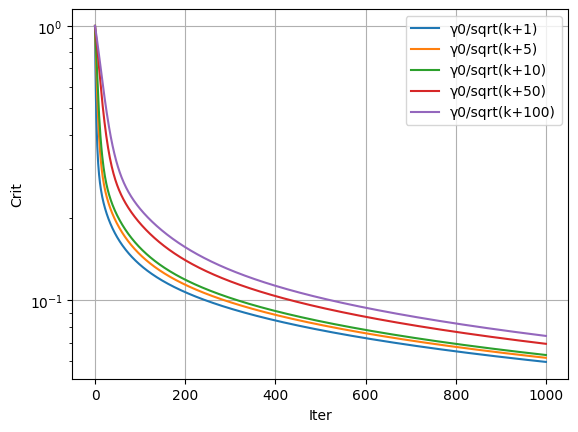

In [ ]:
for res in gd_sqrt_res:
    plt.plot(res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

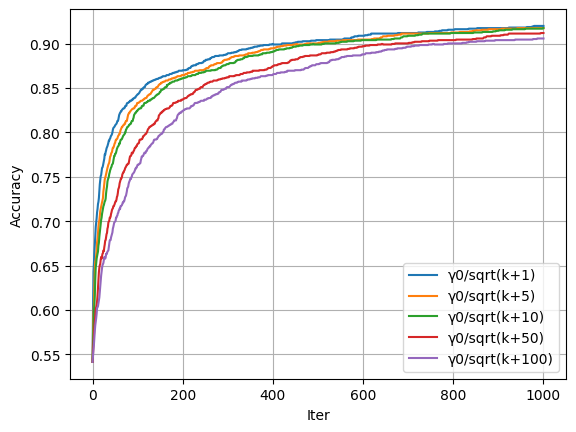

In [ ]:
for res in gd_sqrt_res:
    plt.plot(res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

### Задача 3 (1 балл)

Рассмотрим метод тяжёлого шарика (Heavy Ball)

$$ w^{k+1} = w^k - \gamma_k \nabla \mathcal{L}(w^k) + \tau_k (w^k - w^{k-1}) $$

- Реализуйте шаг метода тяжёлого шарика
- Используйте шаг $\gamma = \frac{1}{L}$.
1. Рассмотрите моментум  $\tau = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$ и несколько моментумов в его окрестности: $s \cdot \tau$, где $s \in [0.9, 1.1]$. Рассмотрите не менее 3-х окрестностей.
2. Рассмотрите моментумы равные  $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ — номер итерации).
3. Сравните полученные результаты.

In [ ]:
class HeavyBall(ManualSolver):
    def __init__(self, lr, beta, init_w, name) -> None:
        super().__init__(lr, name, True, False)
        self.beta = beta if isinstance(beta, Callable) else lambda _: beta
        self.w_prev = init_w

    def step(self, w: np.ndarray, k: int, grad_f: np.ndarray, hess_f: None) -> np.ndarray:
        # TODO: implement heavy ball iteration step
        # YOUR CODE HERE:
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        gamma_k= self.lr(k)
        beta_k= self.beta(k)
        w_next= w - gamma_k*grad_f+beta_k*(w-self.w_prev)
        self.w_prev= w.copy()
        return w_next

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

def beta_k_s(s):
     return lambda k: k / (k + s)

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
tau_star= (np.sqrt(lipschitz_mush)-np.sqrt(lambda_mush))/(np.sqrt(lipschitz_mush)+np.sqrt(lambda_mush))
s_list= [0.90, 1.00, 1.10]

hb_tau_results= []
for s in s_list:
    beta= s*tau_star
    opt= HeavyBall(lr=1.0 / lipschitz_mush, beta=beta, init_w=start_w_mush, name=f'HB τ*s={s:.2f}')
    hb_tau_results.append(test_optimizer(opt))

HB τ*s=1.10: 100%|██████████| 1000/1000 [00:07<00:00, 126.21it/s, Loss=7.85e+13, Accuracy=0.214, Grad norm=4.83e+5]


In [ ]:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
hb_k_results = []
for s in [1, 3, 5]:
    opt = HeavyBall(lr=1.0 / lipschitz_mush, beta=beta_k_s(s), init_w=start_w_mush, name=f'HB k/(k+{s})')
    hb_k_results.append(test_optimizer(opt))

HB k/(k+5): 100%|██████████| 1000/1000 [00:06<00:00, 144.59it/s, Loss=0.0834, Accuracy=0.996, Grad norm=1.46e-5]


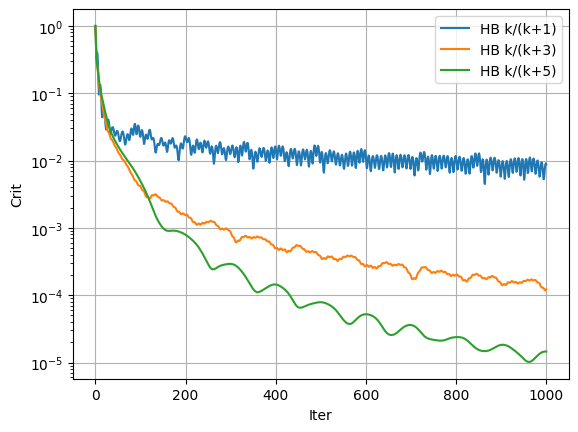

In [ ]:
for result in hb_k_results:
    plt.plot(result['num_iters'], result['Criterion'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

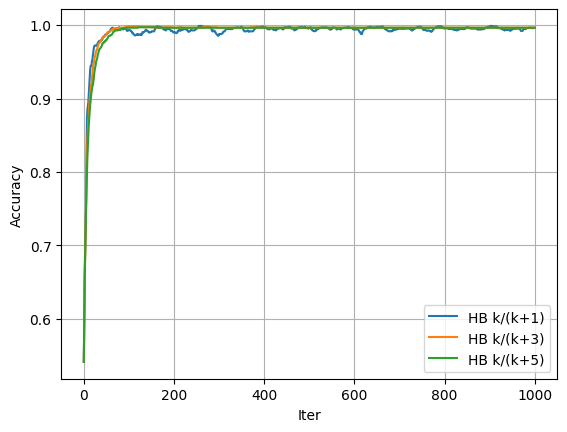

In [ ]:
for result in hb_k_results:
    plt.plot(result['num_iters'], result['Accuracy'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [ ]:
best_final_hb_res = min(hb_k_results, key=lambda x: x['Criterion'][-1])

print(f"Лучший оптимизатор: {best_final_hb_res['name']}")
print(f"Финальная точность: {best_final_hb_res['Accuracy'][-1]:.4f}")

Лучший оптимизатор: HB k/(k+5)
Финальная точность: 0.9963


### Задача 4 (2 балла)

Рассмотрим ускоренный градиентный метод (Nesterov Accelerated Gradient)

$$
\begin{align*}
& w_{k+1} = y_k - \gamma_k \nabla \mathcal{L}(y_k) \\
& y_{k+1} = w_{k+1} + \tau_k (w_{k+1} - w_k)
\end{align*}
$$

- Реализуйте шаг ускоренного градиентного метода
- Используйте шаг $\gamma = \frac{1}{L}$.
1. Рассмотрите моментум  $\tau = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$ и несколько моментумов в его окрестности: $s \cdot \tau$, где $s \in [0.9, 1.1]$. Рассмотрите не менее 3-х окрестностей.
2. Рассмотрите моментумы равные  $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ — номер итерации).
3. Сравните полученные результаты.

In [ ]:
class NAG(ManualSolver):
    def __init__(self, lr, beta, init_w, name) -> None:
        super().__init__(lr, name, False, False)
        self.beta = beta if isinstance(beta, Callable) else lambda _: beta
        self.w_prev = init_w
        self.y_prev = init_w

    def step(self, w: np.ndarray, k: int, grad_f: None, hess_f: None) -> np.ndarray:
        # TODO: implement NAG iteration step
        # YOUR CODE HERE:
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        gamma_k= self.lr(k)
        tau_k= self.beta(k)
        g_y= mush_grad(self.y_prev)
        w_next= self.y_prev - gamma_k * g_y
        y_next= w_next + tau_k * (w_next - w)
        self.y_prev= y_next
        return w_next

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

tau_star = (np.sqrt(lipschitz_mush) - np.sqrt(lambda_mush)) / (np.sqrt(lipschitz_mush) + np.sqrt(lambda_mush))
s_list   = [0.90, 1.00, 1.10]

nag_tau_results = []
for s in s_list:
    opt = NAG(lr=1.0 / lipschitz_mush, beta=s * tau_star, init_w=start_w_mush, name=f'NAG τ*s={s:.2f}')
    nag_tau_results.append(test_optimizer(opt))

NAG τ*s=1.10: 100%|██████████| 1000/1000 [00:07<00:00, 136.21it/s, Loss=1.09e+13, Accuracy=0.541, Grad norm=1.8e+5]


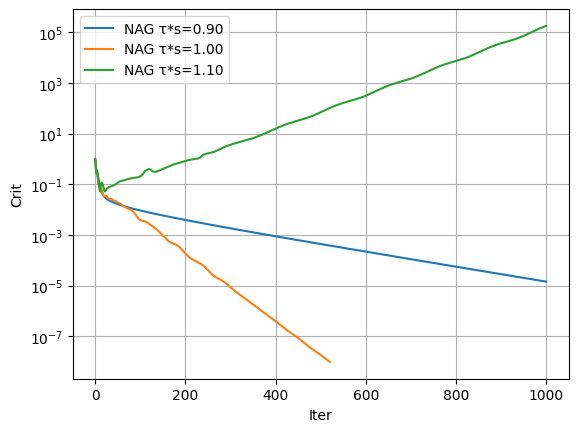

In [ ]:
for result in nag_tau_results:
    plt.plot(result['num_iters'], result['Criterion'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

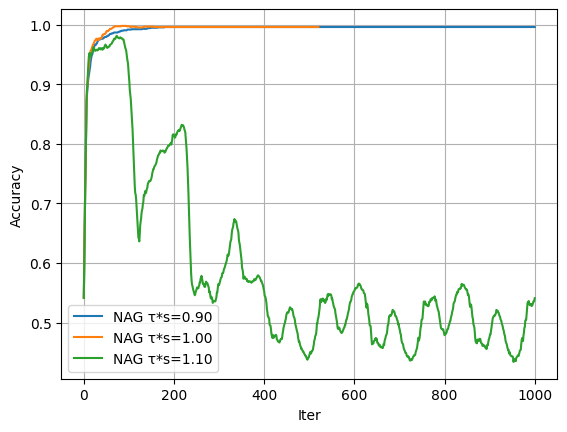

In [ ]:
for result in nag_tau_results:
    plt.plot(result['num_iters'], result['Accuracy'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [ ]:
nag_k_results = []
for s in [1, 3, 5]:
    opt = NAG(lr=1.0 / lipschitz_mush, beta=beta_k_s(s), init_w=start_w_mush, name=f'NAG k/(k+{s})')
    nag_k_results.append(test_optimizer(opt))


NAG k/(k+5): 100%|██████████| 1000/1000 [00:08<00:00, 118.83it/s, Loss=0.0834, Accuracy=0.996, Grad norm=8e-6]


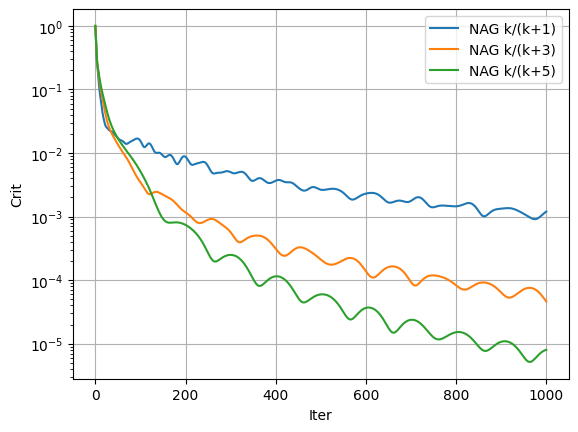

In [ ]:
for result in nag_k_results:
    plt.plot(result['num_iters'], result['Criterion'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

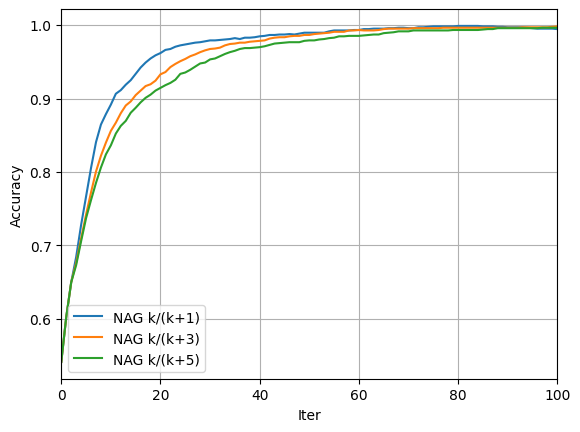

In [ ]:
for result in nag_k_results:
    plt.plot(result['num_iters'], result['Accuracy'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.xlim(0,100)
plt.legend()
plt.grid()

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################

def beta_k_s(s):
    # TODO: return a lambda function that depends on k
    return lambda k: k/(k+s)

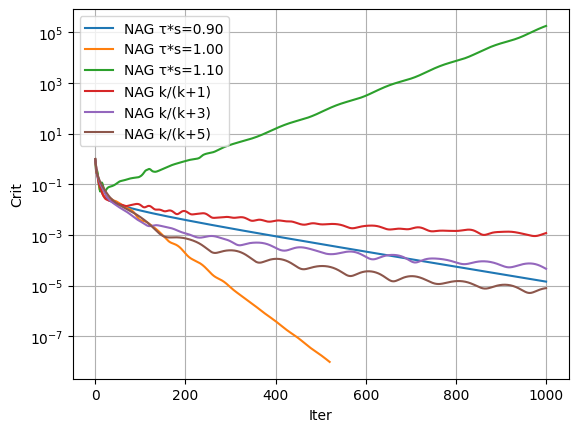

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
all_nag_results = nag_tau_results + nag_k_results

for result in all_nag_results:
    plt.plot(result['num_iters'], result['Criterion'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

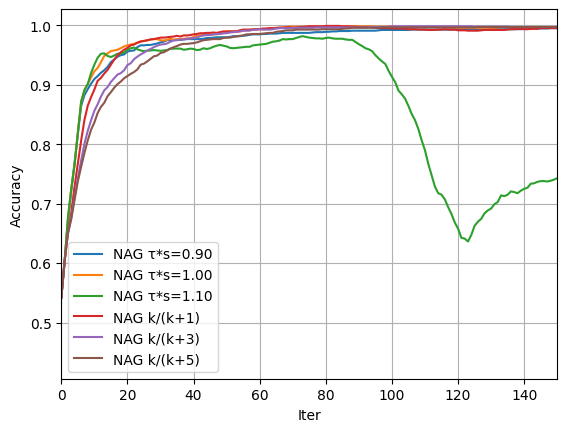

In [ ]:
for result in all_nag_results:
    plt.plot(result['num_iters'], result['Accuracy'], label=result['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.xlim(0,150)
plt.legend()
plt.grid()

In [ ]:
best_final_nag_res = min(nag_k_results, key=lambda x: x['Criterion'][-1])
print(f"Лучший оптимизатор: {best_final_nag_res['name']}")
print(f"Финальная точность: {best_final_nag_res['Accuracy'][-1]:.4f}")

Лучший оптимизатор: NAG k/(k+5)
Финальная точность: 0.9963


### Задача 5 (1 балла)

Рассмотрим один из самых известных методов второго порядка - Метод Ньютона (Newton's method):

$$
w_{k+1} = w_k - \nabla^2\mathcal{L}(w^k)^{-1} \nabla \mathcal{L}(w^k)
$$

А точнее, его модификацию - демпфированный метод Ньютона (Dumped Newton's method):

$$
w_{k+1} = w_k - \gamma_k \nabla^2\mathcal{L}(w^k)^{-1} \nabla \mathcal{L}(w^k)
$$

- Реализуйте шаг демпфированного метода Ньютона
1.  Протестируйте различные $\gamma_k = \gamma = \frac{s}{L}$, где $s \in [0.5, 1.5]$, $L$ - константа липшица в задаче. Рассмотрите не менее 3-х $s$.
2. Сравните полученные результаты.

In [ ]:
class Newton(ManualSolver):
    def __init__(self, lr, name) -> None:
        super().__init__(lr, name, True, True)

    def step(self, w: np.ndarray, k: int, grad_f: np.ndarray, hess_f: np.ndarray) -> np.ndarray:
        # TODO: implement Newton iteration step
        # YOUR CODE HERE:
        ###########################
        ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        ###########################
        gamma_k = self.lr(k)
        reg = 1e-8 * np.eye(len(w))
        newton_dir = np.linalg.solve(hess_f + reg, grad_f)
        w_next = w - gamma_k * newton_dir
        return w_next

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
s_values= [0.5, 1.0, 1.5]
newton_results= []
for s in s_values:
    opt= Newton(lr=s / lipschitz_mush, name=f'Newton {s}/L')
    newton_results.append(test_optimizer(opt))

Newton 1.5/L: 100%|██████████| 1000/1000 [00:24<00:00, 41.49it/s, Loss=378, Accuracy=0.481, Grad norm=1.71]


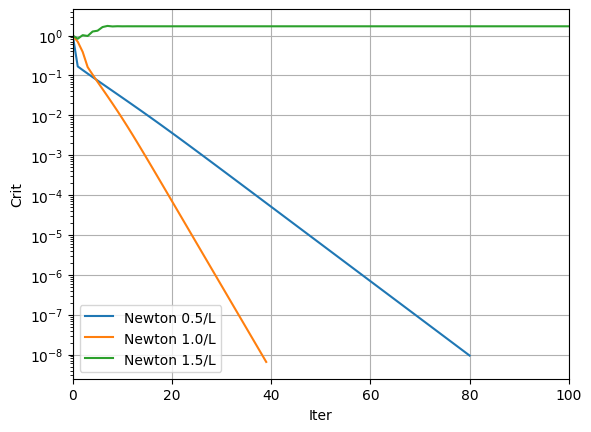

In [ ]:
for res in newton_results:
    plt.plot(res['num_iters'], res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.xlim(0,100)
plt.legend()
plt.grid()

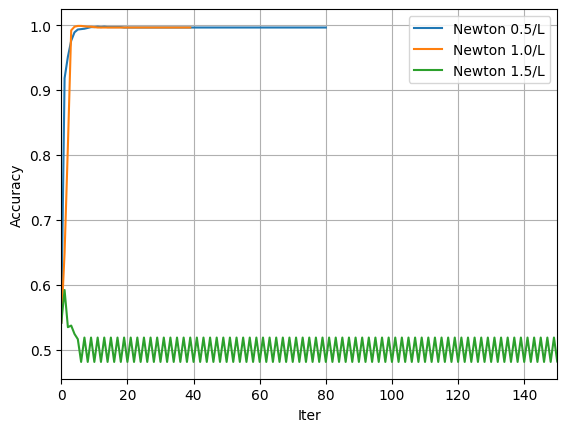

In [ ]:
for res in newton_results:
    plt.plot(res['num_iters'], res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.xlim(0,150)
plt.legend()
plt.grid()

In [ ]:
best_final_newton_res = min(newton_results, key=lambda x: x['Criterion'][-1])
print(f"Лучший оптимизатор: {best_final_newton_res['name']}")
print(f"Финальный критерий: {best_final_newton_res['Criterion'][-1]:.12f}")

Лучший оптимизатор: Newton 1.0/L
Финальный критерий: 0.000000006566


### Сравнение лучших реализаций

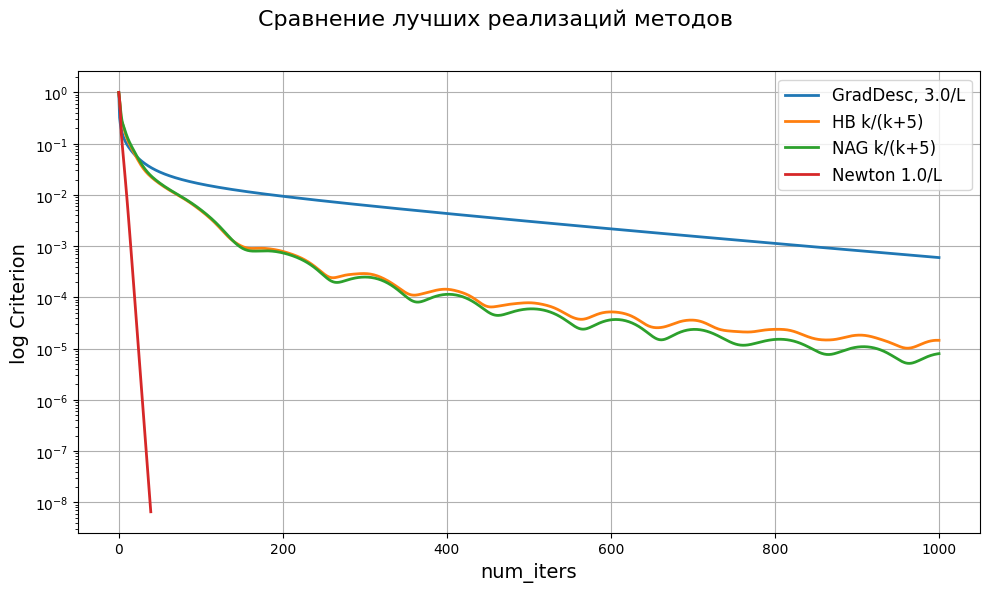

In [ ]:
final_results = [best_final_gd_res, best_final_hb_res, best_final_nag_res, best_final_newton_res]
plot_results(final_results, 'Сравнение лучших реализаций методов', metrics_type=['Criterion'])

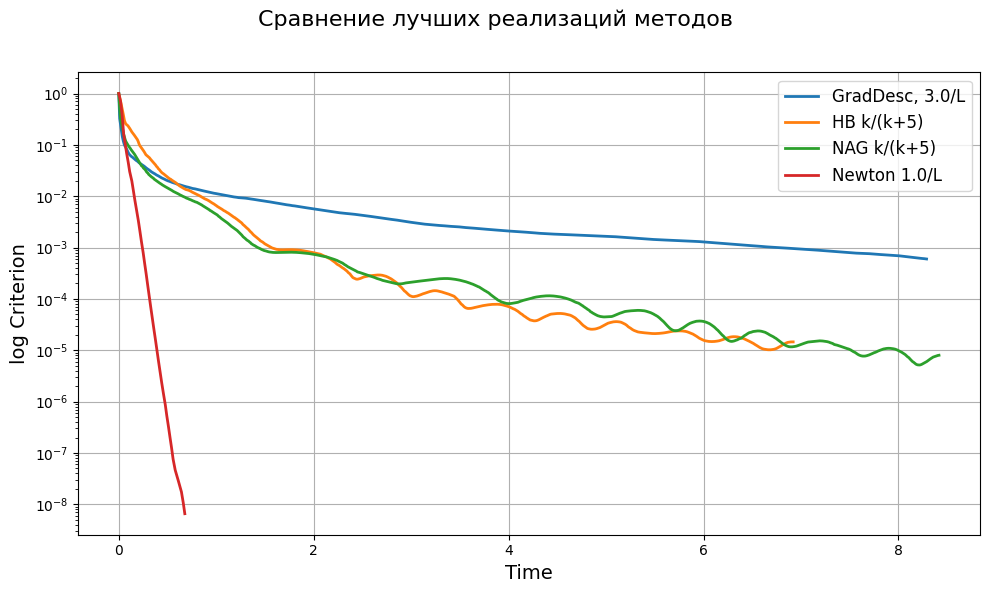

In [ ]:
final_results = [best_final_gd_res, best_final_hb_res, best_final_nag_res, best_final_newton_res]
plot_results(final_results, 'Сравнение лучших реализаций методов', metrics_type=['Criterion'], x='Time')

### Ваши выводы (до 0.5 баллов):

1. Почему предложено выбирать $\gamma = \frac{s}{L}$, $\tau = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$?
2. Почему наблюдаются различия в графиках по количеству итераций и по времени?
3. Любые другие рассуждения приветствуются.

**Ответ:**
1. Вывод был здесь.. https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D0%B8/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F%204/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F%204.pdf
2. По числу итераций метод Ньютона выигрывает


### Задача 6* (1 балл)

Метод проксимального градиентного спуска используется для оптимизации композитной функции потерь
$$
h(w) = f(w) + g(w),
$$
где $f(w)$ является выпуклой дифференцируемой функцией на своей области определения. Особенностью является то, что $g(w)$ не обязательно должна быть дифференцируема всюду на своём множестве определения.  

Мы решаем задачу вида
$$
\min_{w\in \mathbb{R}^d}\{f(w) + R(w)\},
$$
где $R(w)$ - выпуклый (возможно негладкий) регуляризатор.

Обновление параметров осуществляется по схеме
$$
w_{k+1} = prox_{\gamma R}(w_k - \gamma\nabla f(w)),
$$
где проксимальный оператор определяется как
$$
prox_{\gamma R}(v) = \arg\min_{w\in \mathbb{R}^d}\left\{\dfrac{1}{2\gamma}\|w - v\|^2 + R(w) \right\}.
$$

* Реализуйте шаг проксимального градиентного спуска для различных видов $R(w)$ (L1, L2-регуляризация).
1. Протестируйте различные $\gamma_k = \gamma = \frac{s}{L}$, где $L$ определяется согласно $R(w)$.
2. Сравните полученные результаты.

In [ ]:
def lipschitz_no_reg(X: np.ndarray) -> float:
    gram= X.T@X
    lam_max= np.linalg.eigvalsh(gram)[-1]
    return lam_max/(4.0*X.shape[0])

L_no_reg= lipschitz_no_reg(train_mush_x)


In [ ]:
def make_prox_l1(lmbd: float):
    return lambda v, gamma: np.sign(v)*np.maximum(np.abs(v)-gamma*lmbd, 0.0)

def make_prox_l2(lmbd: float):
    return lambda v, gamma: v/(1.0+gamma*lmbd)

class ProxGD(ManualSolver):
    def __init__(self, lr, prox, name: str):
        super().__init__(lr, name, True, False)
        self.prox= prox

    def step(self, w: np.ndarray, k: int, grad_f: np.ndarray, hess_f: np.ndarray) -> np.ndarray:
        gamma_k= self.lr(k)
        lam= globals().get("lambda_mush", 0.0)
        grad_smooth= grad_f-lam*w
        v = w-gamma_k*grad_smooth
        return self.prox(v, gamma_k)

In [ ]:
s_vals = [0.25, 0.5, 1.0, 1.5]
prox_l1_results = []
for s in s_vals:
    opt = ProxGD(lr=(s / L_no_reg),
                 prox=make_prox_l1(lambda_mush),
                 name=f'ProxGD L1 γ={s}/L')
    prox_l1_results.append(test_optimizer(opt))

ProxGD L1 γ=1.5/L: 100%|██████████| 1000/1000 [00:07<00:00, 131.04it/s, Loss=0.102, Accuracy=0.997, Grad norm=0.00976]


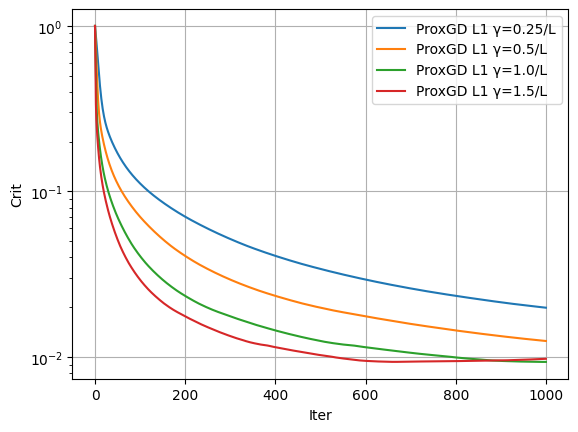

In [ ]:
for res in prox_l1_results:
    plt.plot(res['num_iters'], res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()


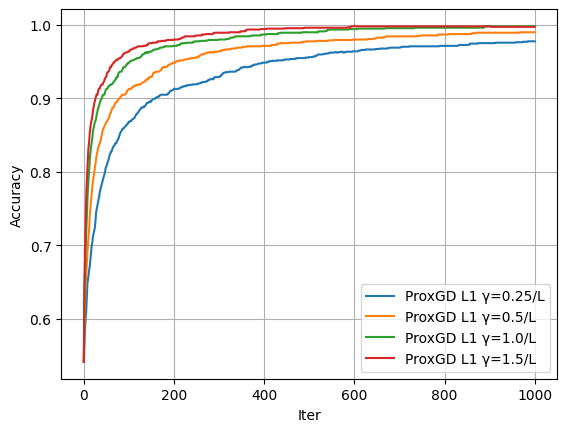

In [ ]:
for res in prox_l1_results:
    plt.plot(res['num_iters'], res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

Ещё вблизи посмотреть:

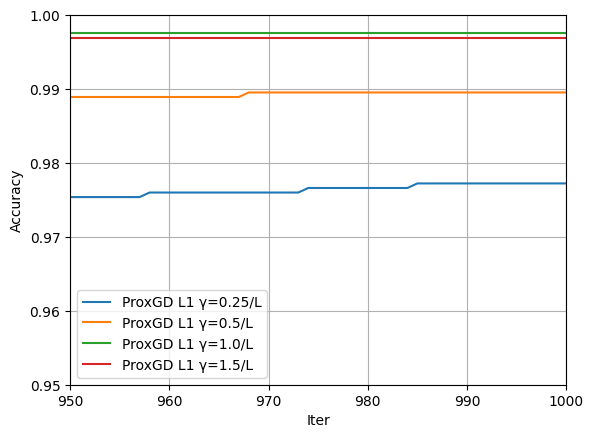

In [ ]:
for res in prox_l1_results:
    plt.plot(res['num_iters'], res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.xlim(950,1000)
plt.ylim(0.95,1.0)
plt.legend()
plt.grid()

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
s_vals = [0.25, 0.5, 1.0, 1.5]
prox_l2_results= []
for s in s_vals:
    opt= ProxGD(lr=(s/L_no_reg),
                 prox=make_prox_l2(lambda_mush),
                 name=f'ProxGD L2: {s}/L')
    prox_l2_results.append(test_optimizer(opt))

ProxGD L2: 1.5/L: 100%|██████████| 1000/1000 [00:07<00:00, 139.53it/s, Loss=0.0864, Accuracy=0.996, Grad norm=0.00306]


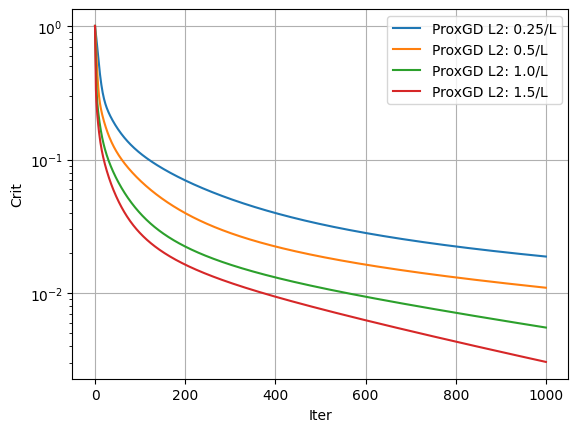

In [ ]:
for res in prox_l2_results:
    plt.plot(res['num_iters'], res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

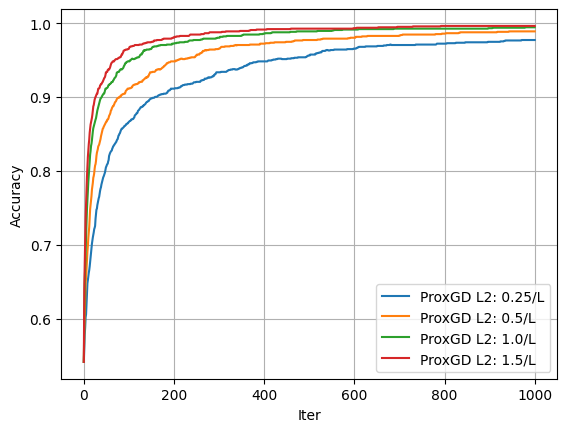

In [ ]:
for res in prox_l2_results:
    plt.plot(res['num_iters'], res['Accuracy'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

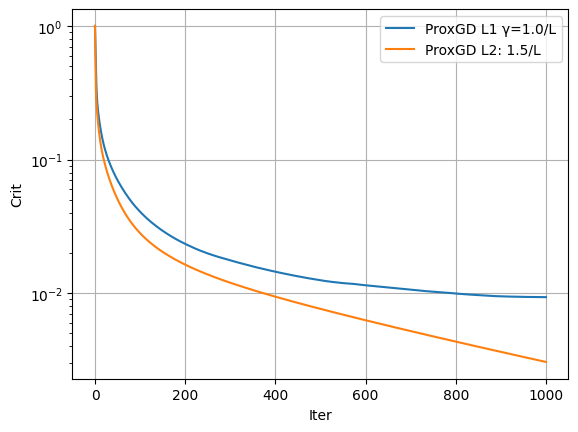

In [ ]:
best_l1= min(prox_l1_results, key=lambda d: d['Criterion'][-1])
best_l2= min(prox_l2_results, key=lambda d: d['Criterion'][-1])
for res in [best_l1, best_l2]:
    plt.plot(res['num_iters'], res['Criterion'], label=res['name'])
plt.xlabel('Iter')
plt.ylabel('Crit')
plt.yscale('log')
plt.legend()
plt.grid()

## Задание 3: Предсказание погоды в Австралии

Датасет содержит ежедневные наблюдения погоды в различных регионах Австралии за период в 10 лет.

Предсказываемым признаком является `RainTomorrow`: "Будет ли завтра дождь?". Это задача бинарной классификации.

Скачиваем датасет

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
url = 'https://huggingface.co/Anm5/rainpred/resolve/main/weatherAUS.csv'
filename = 'weatherAUS.csv'

response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)
df = pd.read_csv(filename)
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Задача 1 (3 балла): Анализ датасета

Датасет представляет собой табличные данные. В этом задании вы убедитесь, что основной объём работы в классификации таких данных с помощью методов машинного обучения состоит в анализе датасета и его признаков.

Давайте выведем общую информацию о признаках в датасете

In [ ]:
df.info()
print(f"Number of NaN targets: {df['RainTomorrow'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Можно заметить, что для некоторых примеров в датасете отсутствует разметка. Поскольку мы решаем задачу классификации с учителем, эти примеры нас не интересуют.

**Удалите из датасета сэмплы с отсутствующим значением `RainTomorrow`**.

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
# Output: `df` variable.
df = df.dropna(subset=['RainTomorrow']).reset_index(drop=True)

Выделим категориальные переменные

In [ ]:
categorical = [var for var in df.columns if df[var].dtype=='O']
print('The categorical variables are :', categorical)
for feature in categorical:
    print(f"Number of unique {feature}:", df[feature].nunique())

The categorical variables are : ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Number of unique Date: 3436
Number of unique Location: 49
Number of unique WindGustDir: 16
Number of unique WindDir9am: 16
Number of unique WindDir3pm: 16
Number of unique RainToday: 2
Number of unique RainTomorrow: 2


`RainTomorrow` является целевым признаком. `RainToday` нетрудно бинаризовать. Остальные признаки содержат большое количество значений.

В первом приближении, удалим признаки кроме `RainTomorrow`, `RainToday`.

**Важно:** датасет без категориальных признаков необходимо записать в отдельную переменную `df_numerical`. Исходный набор `df` пригодится в дополнительном задании.

**Бинаризуйте признаки `RainTomorrow`, `RainToday`. Остальные удалите**

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
# Output: `df_numerical` variable.
df['RainTomorrow']= df['RainTomorrow'].str.strip().str.lower()
df['RainTomorrow']= df['RainTomorrow'].replace({'yes': 1, 'no': 0})

df['RainToday']= df['RainToday'].str.strip().str.lower()
df['RainToday']= df['RainToday'].replace({'yes': 1, 'no': 0})

string_columns = df.select_dtypes(include=['object']).columns

columns_to_keep = [col for col in df.columns
                  if col not in string_columns or
                  col in ['RainTomorrow', 'RainToday']]

df_numerical = df[columns_to_keep].copy()

/tmp/ipython-input-2655966741.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow']= df['RainTomorrow'].replace({'yes': 1, 'no': 0})
/tmp/ipython-input-2655966741.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday']= df['RainToday'].replace({'yes': 1, 'no': 0})


Перейдём к численным признакам

In [ ]:
numerical = [var for var in df.columns if df[var].dtype!='O']
round(df_numerical[numerical].describe(), 2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,141556.00,141871.00,140787.00,81350.00,74377.00,132923.00,140845.00,139563.00,140419.00,138583.00,128179.00,128212.00,88536.00,85099.00,141289.00,139467.00,140787.00,142193.00
mean,12.19,23.23,2.35,5.47,7.62,39.98,14.00,18.64,68.84,51.48,1017.65,1015.26,4.44,4.50,16.99,21.69,0.22,0.22
std,6.40,7.12,8.47,4.19,3.78,13.59,8.89,8.80,19.05,20.80,7.11,7.04,2.89,2.72,6.49,6.94,0.42,0.42
min,-8.50,-4.80,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,977.10,0.00,0.00,-7.20,-5.40,0.00,0.00
25%,7.60,17.90,0.00,2.60,4.90,31.00,7.00,13.00,57.00,37.00,1012.90,1010.40,1.00,2.00,12.30,16.60,0.00,0.00
50%,12.00,22.60,0.00,4.80,8.50,39.00,13.00,19.00,70.00,52.00,1017.60,1015.20,5.00,5.00,16.70,21.10,0.00,0.00
75%,16.80,28.20,0.80,7.40,10.60,48.00,19.00,24.00,83.00,66.00,1022.40,1020.00,7.00,7.00,21.60,26.40,0.00,0.00
max,33.90,48.10,371.00,145.00,14.50,135.00,130.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.70,1.00,1.00


Одним из важных аспектов обработки численных признаков является *опеределение выбросов (англ. outliers)*. С одной стороны, выбросы можно выделить для всех признаков. Однако, бывает полезно изучить, для каких фичей они более характерны. Это позволит избежать потери важной информации.

**Вам необходимо определить, для каких из численных признаков имеет смысл выделять выбросы.**

**Примечание:** Это можно сделать с помощью графика гистограммы. Отрисуйте зависимости всех числовых признаков от целевого `RainTomorrow`. По оси x отложите значения признака, по оси y - плотность `RainTomorrow` (в результате на рисунке будут 2 графика для каждого из бинарных значений). Для этого воспользуйтесь функцией `seaborn.histplot` с аргументом `stat='density'`. По виду графика можно интерпретировать, для каких признаков существуют значительные выбросы.

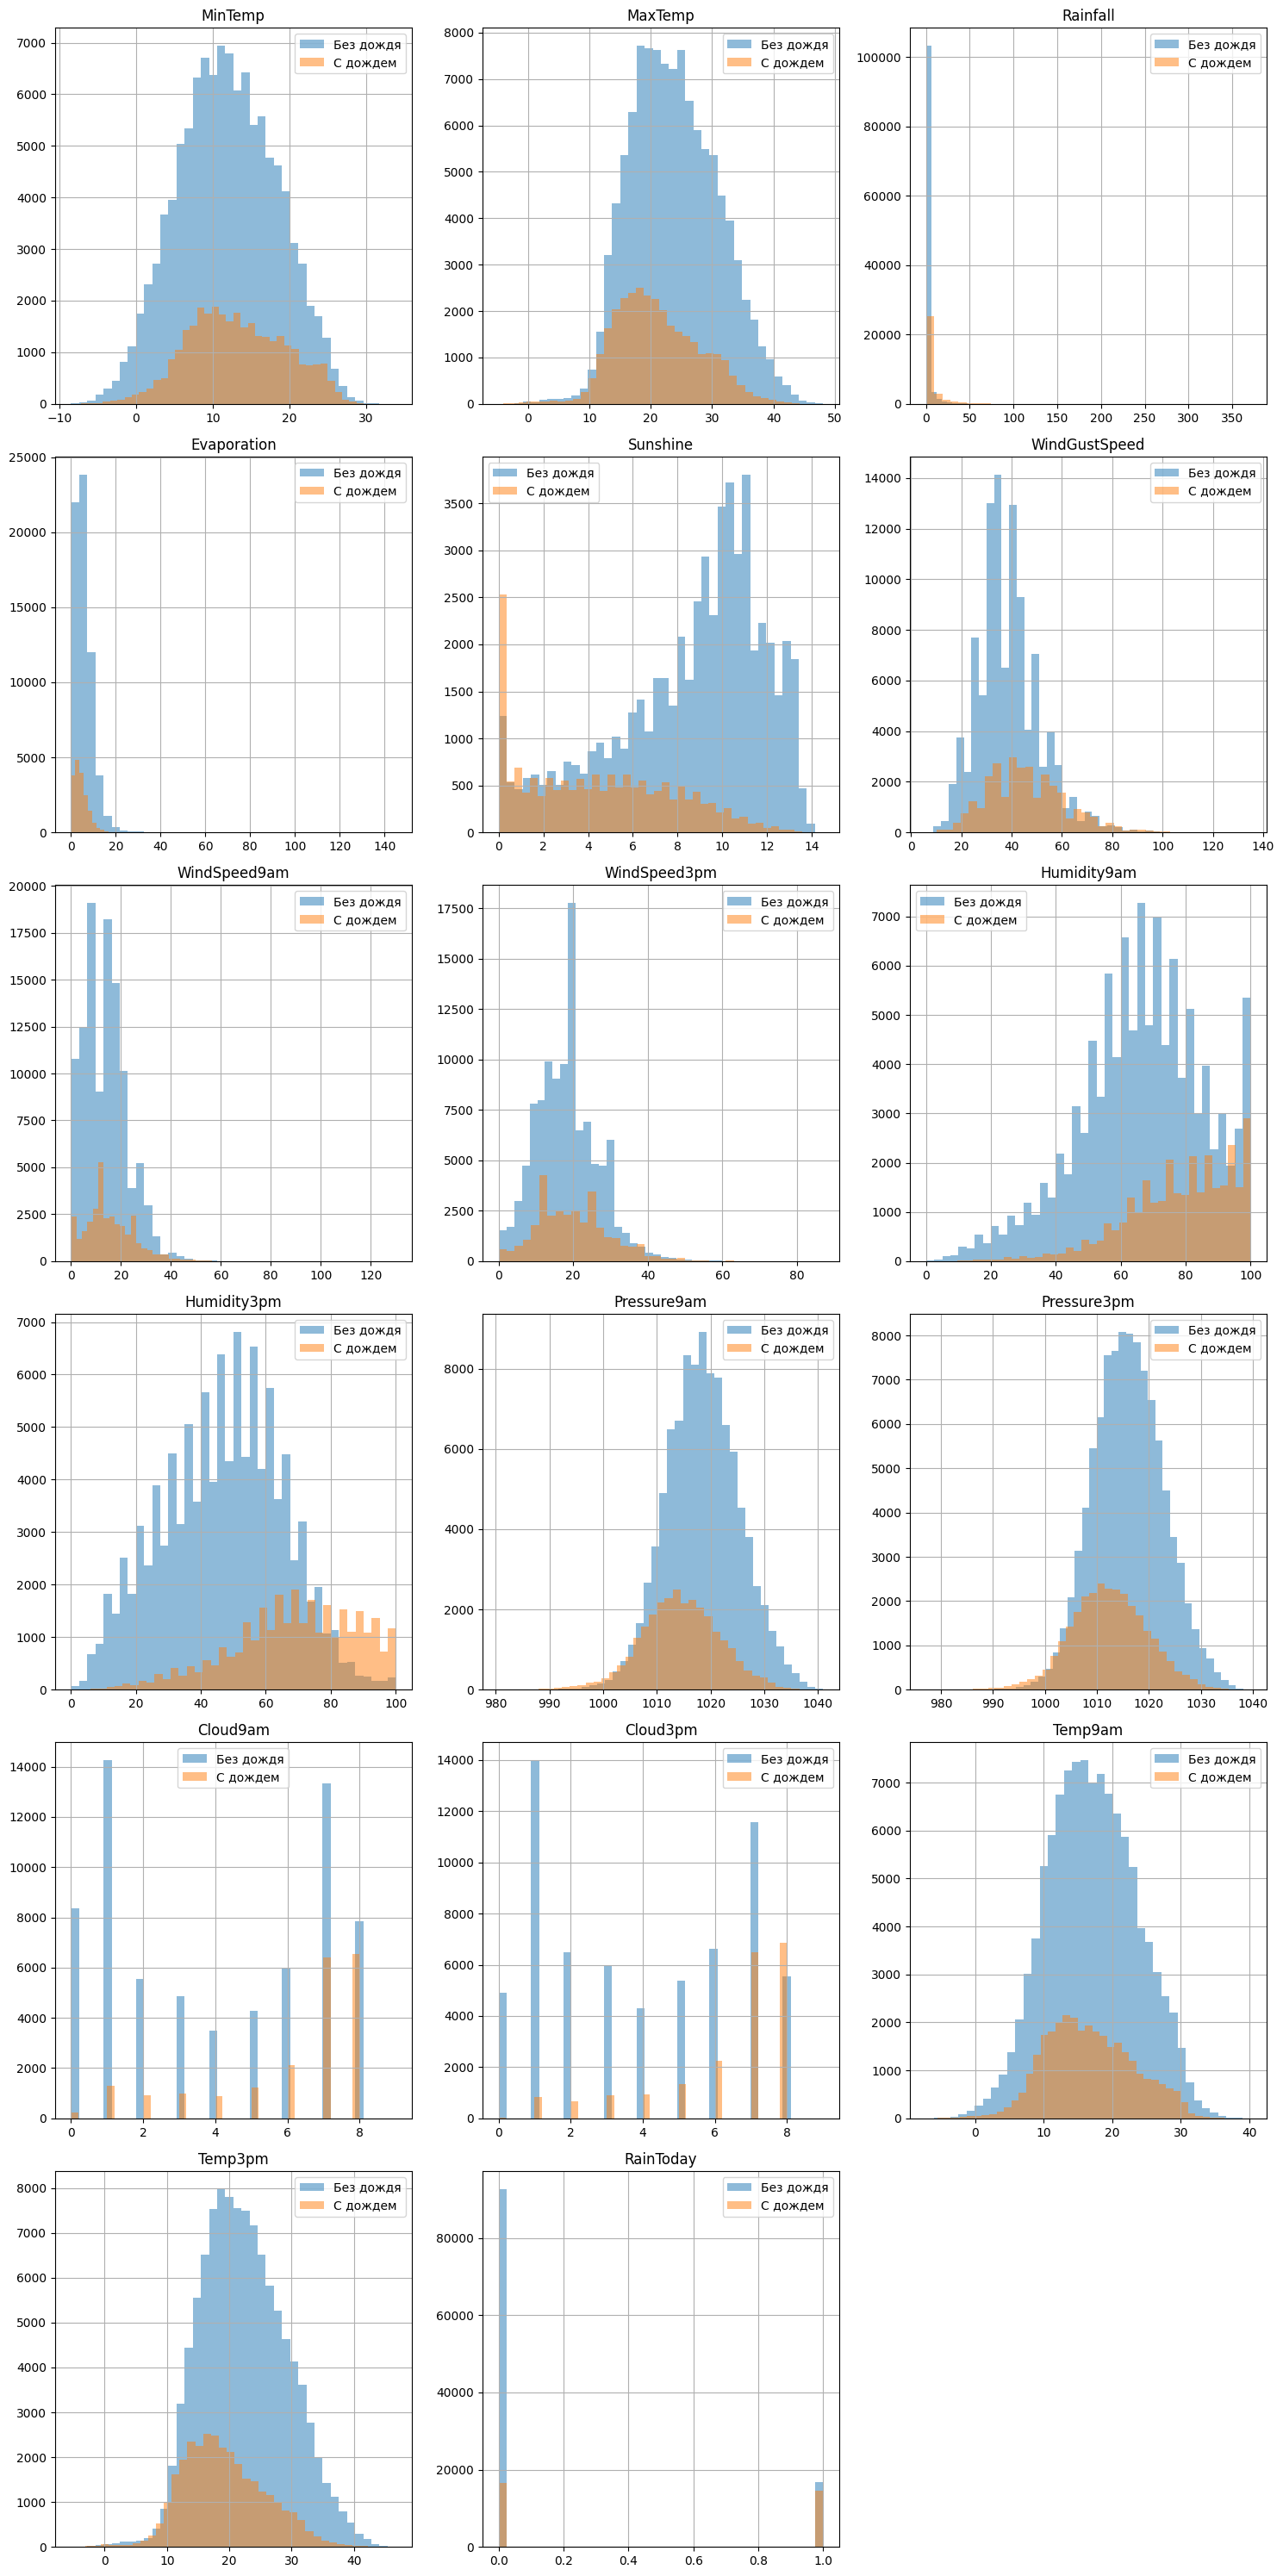

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
numeric_columns= df_numerical.select_dtypes(include=['number']).columns
feature_columns= [col for col in numeric_columns if col != 'RainTomorrow']

num_plots= len(feature_columns)
num_cols= 3
num_rows= (num_plots + num_cols - 1) // num_cols

fig, axes= plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

if num_rows == 1:
    axes= [axes] if num_cols == 1 else axes
else:
    axes= axes.flatten()

for i, column in enumerate(feature_columns):
    ax= axes[i]

    data_no_rain= df_numerical[df_numerical['RainTomorrow'] == 0][column]
    data_rain= df_numerical[df_numerical['RainTomorrow'] == 1][column]
    ax.hist(data_no_rain, bins=40, alpha=0.5, label='Без дождя')
    ax.hist(data_rain, bins=40, alpha=0.5, label='С дождем')
    ax.set_title(column)
    ax.legend()
    ax.grid()

for i in range(num_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Графики признаков с выбросами имеют характерное *смещение (англ. skew)*. Для смещённых распределений, выбросы можно определить через *межквартильное расстояние (англ. Interquartile Range).*
$$
IQR = Q3 - Q1,
$$
где $Q3$ - третий квартиль, соответствующий порогу $75\%$, $Q1$ - первый квартиль, соответствующий порогу $25\%$.

Тогда выбросы определяют согласно правилу:
*  *Нижний выброс* - $x < Q1 - 1.5\cdot IQR$, $x$ - значение признака;
*  *Верхний выброс* - $x > Q3 + 1.5\cdot IQR$.

Если в результате получилось слишком много выбросов, значение $1.5$ можно увеличить, выделяя более "явные".

**Для полученных числовых признаков выделите соответствующие выбросы с помощью $IQR$ с коэффициентом 2**.

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
# Output: `outliers` variable.
num_cols= df_numerical.select_dtypes(include='number').columns.tolist()
feat_cols= [c for c in num_cols if c not in ['RainTomorrow', 'RainToday']]

Q1= df_numerical[feat_cols].quantile(0.25)
Q3= df_numerical[feat_cols].quantile(0.75)
IQR= Q3 - Q1

low, high= Q1-2.0*IQR, Q3+2.0*IQR
outliers= ((df_numerical[feat_cols]<low) | (df_numerical[feat_cols]>high)).fillna(False)

Есть 2 стратегии работы с выбросами:
*   Удалить соответствующий сэмпл;
*   Заменить его на среднее/медиану.

В первом приближении, удалим соответствующие примеры.

In [ ]:
df_num_no_outliers = df_numerical[~outliers.any(axis=1)].reset_index(drop=True)

Базовый анализ датасета почти закончен! Осталась пара шагов.

Выделим целевой признак в соответствующую переменную. Посмотрим на пропуски в обучающей выборке.

In [ ]:
X = df_num_no_outliers.drop(['RainTomorrow'], axis=1)
y = df_num_no_outliers['RainTomorrow']
X.isnull().sum()

,0
MinTemp,550
MaxTemp,271
Rainfall,1367
Evaporation,49971
Sunshine,55727
WindGustSpeed,7347
WindSpeed9am,1150
WindSpeed3pm,2108
Humidity9am,1398
Humidity3pm,2857


Пропуски необходимо заполнить. Обычно это делают с помощью среднего/медианы. Мы воспользуемся медианой, так как она более устойчива к выбросам.

**Заполните пропуски в обучающей выборке медианой.**

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
X = X.fillna(X.median(numeric_only=True))

Наконец, осталось провести нормализацию значений.

Разделим выборку на обучающую и тестовую, чтобы не учитывать масштаб на тесте.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.describe()

Для нормализации будем использовать `MinMaxScaler` модуля `sklearn.preprocessing`.

**Вам необходимо "обучить" (`fit`) scaler на `X_train` и использовать его на `X_test` (`transform`).**

**Примечание:** выходом `MinMaxScaler` является `np.array`. Чтобы в дальнейшем работать с выборкой, после масштабирования необходимо обратно перевести её в `pd.DataFrame`.

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
# Output: `X_train`, `X_test`: pd.DataFrame type.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_test_arr  = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_arr, columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(X_test_arr,  columns=X_test.columns,  index=X_test.index)

### Задача 2 (5 баллов): Классификация



* Вам необходимо обучить обработанный датасет с помощью логистической регрессии.
* Вы можете пользоваться библиотекой `sklearn`
* Проведите классификацию с L1 и L2-регуляризацией. Какие признаки регуляризация lasso посчитала неинформативными?
* Проведите классификацию с регуляризацией [elasticnet](https://en.wikipedia.org/wiki/Elastic_net_regularization). Для этого воспользуйтесь поиском по сетке гиперпараметров (`GridSearchCV` модуля `sklearn.model_selection`). Пространство поиска определите константой `C = [1, 2, 5, 10, 100]` и значением `l1_ratio = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`.
* Сделайте выводы по полученым результатам




In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
lr_l1= LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000, random_state=42)
lr_l1.fit(X_train, y_train)
y_tr_l1= lr_l1.predict(X_train)
y_te_l1= lr_l1.predict(X_test)
acc_tr_l1= accuracy_score(y_train, y_tr_l1)
acc_te_l1= accuracy_score(y_test,  y_te_l1)

coef_l1= lr_l1.coef_.ravel()
zero_idx= np.isclose(coef_l1, 0.0, atol=1e-9)
lasso_zero_features= list(X_train.columns[zero_idx])

print(f"Для L1: Train accuracy={acc_tr_l1} \t Test accuracy={acc_te_l1}")

Для L1: train acc=0.8639696803770628 	 test acc=0.8646826419307738


In [ ]:
lr_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=5000, random_state=42)
lr_l2.fit(X_train, y_train)
acc_tr_l2 = accuracy_score(y_train, lr_l2.predict(X_train))
acc_te_l2 = accuracy_score(y_test,  lr_l2.predict(X_test))
print(f"Для L2: Train accuracy={acc_tr_l2} \t Test accuracy={acc_te_l2}")

Для L2: Train accuracy=0.8639052619147314 	 Test accuracy=0.8646826419307738


In [ ]:
param_grid= {"C": [1, 2, 5, 10, 100], "l1_ratio": [i/10 for i in range(11)]}
base_el= LogisticRegression(penalty="elasticnet", solver="saga", max_iter=5000, random_state=42)
gs= GridSearchCV(estimator=base_el, param_grid=param_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=0, refit=True)
gs.fit(X_train, y_train)
best_el= gs.best_estimator_
acc_tr_el= accuracy_score(y_train, best_el.predict(X_train))
acc_te_el= accuracy_score(y_test,  best_el.predict(X_test))

print(f"Для elasticnet: best params: {gs.best_params_}")
print(f"Для elasticnet: Train accuracy={acc_tr_el} \t Test accuracy={acc_te_el}")

Для elasticnet: best params: {'C': 1, 'l1_ratio': 0.2}
Для elasticnet: Train accuracy=0.8638837890939544 	 Test accuracy=0.8646396976724212


Качество почти одинаковое у всех трёх. Переобучения нет так как близки acc на test и train. Elasticnet выбрал 0.2 (ближе к L2)

### Задача 3* (2 балла): Категориальные признаки

* В ходе анализа датасета было сделано несколько упрощений:
    * Категориальные признаки были опущены (`df --> df_numerical`);
    * Выбросы были опущены (`df_numerical --> df_num_no_outliers`).
* Необходимо провести обработку категориальных признаков.
* Протестировать качество логистической регрессии и подобрать гиперпараметры на различных вариантах:
    * С категориальными признаками и без учета выбросов;
    * Без категориальных признаков, с учетом выбросов;
    * С категориальными признаками, с учетом выбросов.
* Поощряется изобретательность. Возможно, какие-то категориальные/численные признаки покажутся менее инфомативными.


* P.S. Не расстраивайтесь, если выдвигаемые гипотезы не дадут прибавки в качестве. Важен сам пайплайн проверки выдвигаемых гипотез)

In [ ]:
# YOUR CODE HERE:
###########################
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
###########################
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
df_both = df.drop(columns=['Date']).copy()
df_num_only = df_numerical.copy()
df_clean = df_both[~outliers.any(axis=1)]

In [ ]:
def test_model(data, use_cats, name):
    X= data.drop('RainTomorrow', axis=1)
    y= data['RainTomorrow'].astype(int)

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

    if use_cats:
        num_cols= X.select_dtypes(include='number').columns
        cat_cols= X.select_dtypes(exclude='number').columns
        preprocessor= ColumnTransformer([('num', SimpleImputer(strategy='median'), num_cols), ('cat', OneHotEncoder(), cat_cols)])

    else:
        preprocessor= SimpleImputer(strategy='median')

    model= LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)
    pipe= Pipeline([('preprocess', preprocessor), ('model', model)])
    params= {'model__C': [1, 10, 100],      'model__l1_ratio': [0, 0.5, 1]}

    grid= GridSearchCV(pipe, params, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    train_acc= grid.score(X_train, y_train)
    test_acc= grid.score(X_test, y_test)
    print(f"{name}: Train={train_acc:.3f}, Test={test_acc:.3f}")

    return test_acc

Запускалось дольше среднего..

In [ ]:
test_model(df_both, True, "Категории, выбросы")
test_model(df_num_only, False, "Без категориальных, с выбросами")
test_model(df_clean, True, "С категориями, без выбросов")

KeyboardInterrupt: 

Результаты получить не вышло, зато можно ещё предложить идею выкинуть ещё пару параметров, у которых с другими очень высокая корреляция:

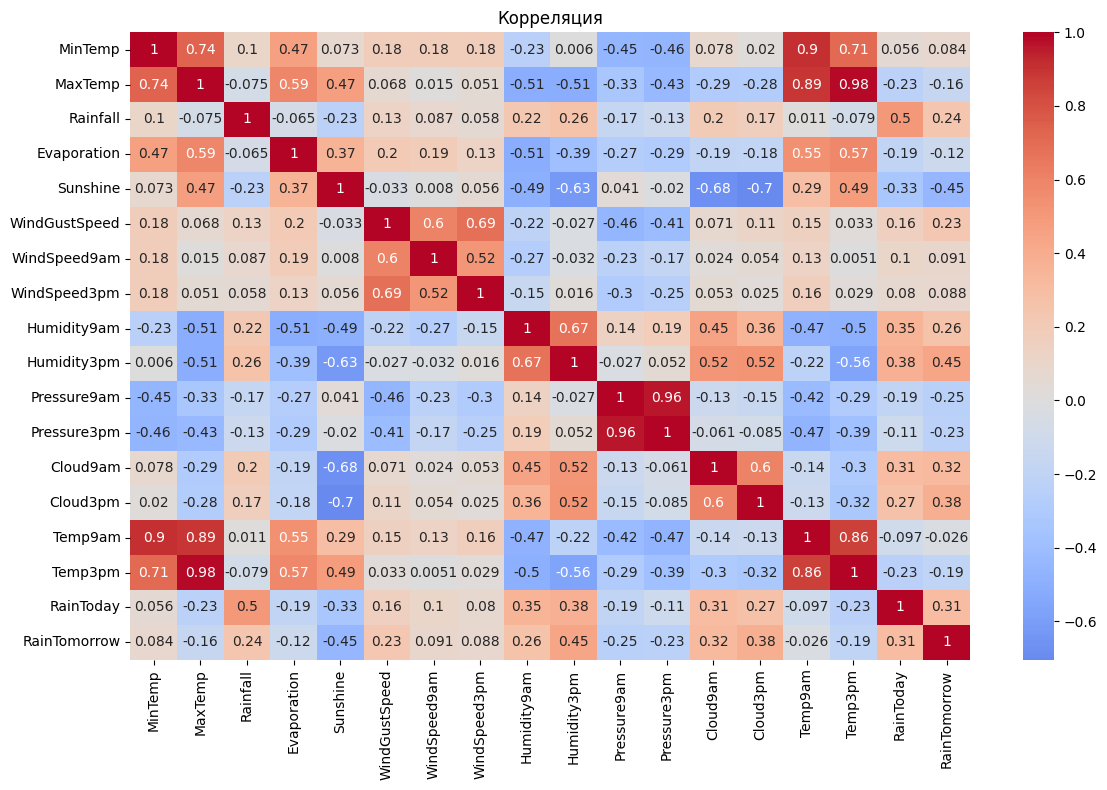

In [ ]:
correlation= df_numerical.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция')
plt.tight_layout()
plt.show()